In [1]:
import jax.numpy as np
import cvxpy as cp
import jax
import matplotlib.pyplot as plt
import gurobipy

from dataclasses import dataclass

In [41]:
# hyperparameter definition
N = 100
t0 = 0
m0 = 2.0
alpha = 0.0034
r0 = np.array([4.5, 16.5])
rf = np.array([0.0, 0.0])
v0 = np.array([-10.0, -1.5])
vf = np.array([0.0, 0.0])
omega0 = 0
omegaf = 0
theta0 = 0
thetaf = 0
g = -1.0
gamma_min = 1.5
gamma_max = 6.5
tau_max = 1
J = 0.25
terminal_weight = 100.0
trust_weight = 1.0

We will define our state as follows:

\begin{align*}
    x = \begin{bmatrix} m(t)\\r(t)\\v(t)\\\theta(t)\\\omega(t) \end{bmatrix}
\end{align*}

It is important to note that both $r$ and $v$ are denoted in y-z coordinates.

We define our control vector as follows:

\begin{align*}
    u = \begin{bmatrix} \Gamma(t)\\\tau(t) \end{bmatrix}
\end{align*}

In [42]:
def f(x, u, params):
    '''
    State-space dynamics for the planar descent vehicle
    Inputs:
        x = [m, r, v, omega, theta] has 7 elements
        u = [Gamma, tau] has 2 elements
    Outputs:
        xdot = [m_dot, r_dot, v_dot, omega_dot, theta_dot] has 7 elements
    '''

    # extract state and control variables
    m = x[0]
    r = x[1:3]
    v = x[3:5]
    omega = x[5]
    theta = x[6]
    Gamma = u[0]
    tau = u[1]

    # extract the parameters
    alpha = params.alpha
    g = params.g * np.array([0, 1])
    J = params.J

    # other intermdeiate variables
    d = np.array([-np.sin(theta), np.cos(theta)])

    m_dot = -alpha * Gamma
    r_dot = v
    v_dot = Gamma / m * d + g
    theta_dot = omega
    omega_dot = tau / J

    xdot = np.array([m_dot, r_dot[0], r_dot[1], v_dot[0], v_dot[1], omega_dot, theta_dot])
    return xdot

In [32]:
def A_jac(x, u, params):
    m = x[0]
    r = x[1:3]
    v = x[3:5]
    omega = x[5]
    theta = x[6]
    Gamma = u[0]
    tau = u[1]


    # extract the parameters
    alpha = params.alpha
    g = params.g * np.array([0, 1])
    J = params.J

    A = np.array([
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [Gamma/m**2 * np.sin(theta), 0., 0., 0., 0., Gamma/m * np.cos(theta), 0.],
        [-Gamma/m**2 * np.cos(theta), 0., 0., 0., 0., -Gamma/m * np.sin(theta), 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]
    ])

    return A

def B_jac(x, u, params):
    m = x[0]
    r = x[1:3]
    v = x[3:5]
    omega = x[5]
    theta = x[6]
    Gamma = u[0]
    tau = u[1]


    # extract the parameters
    alpha = params.alpha
    g = params.g * np.array([0., 1.])
    J = params.J

    B = np.array([
        [-alpha, 0.],
        [0., 0.],
        [0., 0.],
        [-np.sin(theta)/m, 0.],
        [np.cos(theta)/m, 0.],
        [0., 0.],
        [0., 1/J]
    ])

    return B

def C_jac(x, u, A, B, params):
    return f(x, u, params) - A @ x - B @ u


In [33]:
def linearize_dynamics(x, u, params):
    A = jax.jacfwd(f, argnums=0)(x, u, params)
    B = jax.jacfwd(f, argnums=1)(x, u, params)
    C = f(x, u, params) - A @ x - B @ u
    return A, B, C

In [34]:
def discrete_step(x_bar, u_bar, x, u, params):
    dt = params.dt
    A, B, C = linearize_dynamics(x_bar, u_bar, params)
    return (A * dt + np.eye(A.shape[0])) @ x + (B * dt) @ u + C
    

In [35]:
def scaled_dynamics(x, u, t_f, params):
    return t_f * f(x, u, params)

Next, we need to assign the parameters that go into our dynamics as an object

In [36]:
@dataclass
class Params:
    N: int
    dt: float
    alpha: float
    g: float
    J: float
    tau_max: float
    gamma_min: float
    gamma_max: float

In [37]:
problem_params = Params(N=N, dt=0.1, alpha=alpha, g=g, J=J, tau_max=tau_max, gamma_min=gamma_min, gamma_max=gamma_max)

Next, we need to linearize our dynamics since they are nonlinear

In [54]:
x0 = np.array([m0, *r0, *v0, omega0, theta0])
u0 = np.array([0.0, 0.0])
t_f = 100
dt = t_f / N
A, B, C = linearize_dynamics(x0, u0, problem_params)

tf_min = 20.
tf_max = 60.

# Formulating as an SCP problem

In [57]:
x0 = np.array([m0, *r0, *v0, omega0, theta0])
u0 = np.array([1.5, 0.0])
xf = np.array([2.8, *rf, *vf, omegaf, thetaf])
uf = np.array([1.5, 0.0])

x_guess = np.linspace(x0, xf, N+1)
u_guess = np.linspace(u0, uf, N)

for i in range(1):
    x = cp.Variable((N+1, 7))
    u = cp.Variable((N, 2))
    # tf = cp.Variable(pos=True)
    epsilon = cp.Variable((2,))

    cost = 0
    constraints = []

    # cost += cp.sum_squares(u[:, 0])    
    cost += cp.sum(u[:, 0])
    # cost += tf
    cost += cp.quad_form(x[-1, 3:5] - xf[3:5], terminal_weight * np.eye(2))
    cost += cp.quad_form(x[-1, 1:3] - xf[1:3], terminal_weight * np.eye(2))
    cost += sum(cp.quad_form(x[i, :] - x_guess[i, :], trust_weight * np.eye(7)) for i in range(N+1))    
    cost += 10 * epsilon[0]
    cost += 10 * epsilon[1]
    
    constraints += [x[0] == x0]
    constraints += [u[:, 0] >= gamma_min]
    constraints += [u[:, 0] <= gamma_max]
    constraints += [u[:, 1] <= tau_max]
    constraints += [u[:, 1] >= -tau_max]
    # constraints += [x[-1, 1:3] == xf[1:3]]
    constraints += [x[:, 1] >= -epsilon[0]]
    constraints += [epsilon >= 0.0]
    # constraints += [x[:, 3:5] == xf[3:5]]
    # constraints += [tf >= tf_min]
    # constraints += [tf <= tf_max]

    # dt = tf / N
    for i in range(N):
        A = A_jac(x_guess[i, :], u_guess[i, :], problem_params)
        B = B_jac(x_guess[i, :], u_guess[i, :], problem_params)
        C = C_jac(x_guess[i, :], u_guess[i, :], A, B, problem_params)
        constraints += [x[i+1] == (A @ x[i] + (B) @ u[i] + C) * dt + x[i]]
        # constraints += [x[i+1] == discrete_step(x_guess[i, :], u_guess[i, :], x[i, :], u[i, :], problem_params)]

    objective = cp.Minimize(cost)
    problem = cp.Problem(objective, constraints)
    # could use any cvx solver here
    problem.solve(solver=cp.GUROBI, verbose=True)
    problem = None

    x_guess = x.value
    u_guess = u.value


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Mar 08 05:33:44 PM: Your problem has 909 variables, 1210 constraints, and 0 parameters.
(CVXPY) Mar 08 05:33:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 08 05:33:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 08 05:33:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 08 05:33:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 08 05:33:44 PM: Compiling problem (target solver=GUROBI)

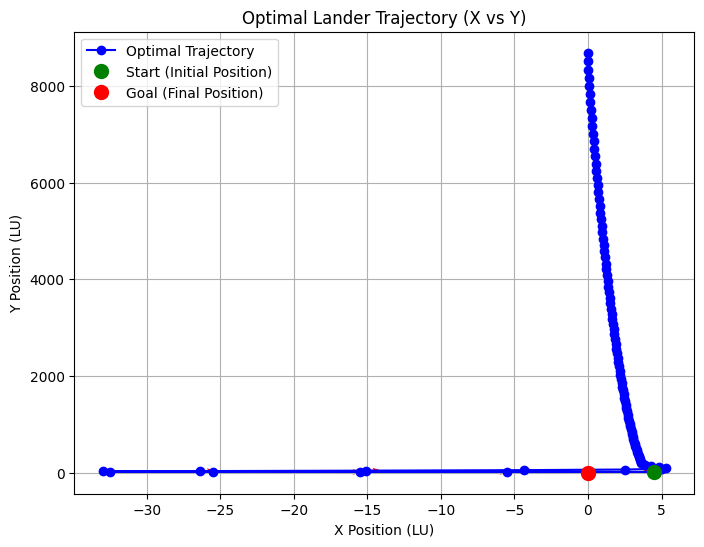

In [58]:
r_x = x.value[:, 1]  # x position
r_y = x.value[:, 2]  # y position
v_x = x.value[:, 3]
v_y = x.value[:, 4]

# Plot the trajectory
plt.figure(figsize=(8, 6))
plt.plot(r_x, r_y, 'bo-', label="Optimal Trajectory")  # Blue line with circles
plt.plot(x0[1], x0[2], 'go', markersize=10, label="Start (Initial Position)")  # Green start point
plt.plot(xf[1], xf[2], 'ro', markersize=10, label="Goal (Final Position)")  # Red target point

# Add velocity vector arrows
scale_factor = 0.1  # Adjust for arrow size
plt.quiver(r_x, r_y, v_x, v_y, angles='xy', scale_units='xy', scale=1/scale_factor, color='r', width=0.003)

# Labels and formatting
plt.xlabel("X Position (LU)")
plt.ylabel("Y Position (LU)")
plt.title("Optimal Lander Trajectory (X vs Y)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [44]:
x.value[-1]

array([ 1.82800522e+00, -0.00000000e+00, -0.00000000e+00,  2.74812780e-03,
       -8.74975894e+02, -3.55900606e-02,  3.51056489e-11])